In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/babsatestset/test_set.csv


In [2]:
!pip install bitsandbytes accelerate

In [3]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoModelForSeq2SeqLM
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import re
import getpass # To securely ask for the token


In [4]:
# Set a style for plots and fonts
plt.style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['Hind Siliguri', 'SolaimanLipi', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

In [5]:
def create_dummy_test_file():
    # ... (same function as before)
    data = { 'Review': [ "খাবারটা দারুন কিন্তু পরিবেশটা খুব নোংরা।", "সার্ভিস খুবই স্লো, তবে স্টাফরা বিনয়ী।", "দাম একটু বেশি মনে হলেও খাবারের মান ভালো।", "বইটির প্রিন্ট কোয়ালিটি চমৎকার এবং ডেলিভারিও দ্রুত ছিল।", "ফোনটা ভালোই, কিন্তু ব্যাটারি ব্যাকআপ হতাশাজনক।" ], 'Aspects': [ "খাবার, পরিবেশ", "সার্ভিস, স্টাফ", "দাম, খাবারের মান", "প্রিন্ট কোয়ালিটি, ডেলিভারি", "ফোন, ব্যাটারি" ], 'Sentiments': [ "positive, negative", "negative, positive", "negative, positive", "positive, positive", "neutral, negative" ] }
    pd.DataFrame(data).to_csv('test.csv', index=False)
    print("Dummy 'test.csv' created.")

In [6]:
MODEL_CONFIG = {
    "Ministral-8B-Instruct": 'mistralai/Ministral-8B-Instruct-2410',
}
TEST_FILE_PATH = '/kaggle/input/babsatestset/test_set.csv'
BATCH_SIZE = 16

In [ ]:
#try:
 #   HF_TOKEN = os.environ.get("HF_TOKEN") or getpass.getpass("Enter your Hugging Face token: ")
#except (ImportError, ModuleNotFoundError):
 #   HF_TOKEN = input("Enter your Hugging Face token: ")

In [8]:
def load_model_and_tokenizer(model_id, token):
    # ... (This function remains the same as the last version) ...
    # It correctly loads the model using the right class and quantization.
    # We will add one thing: setting the padding side for Causal LMs.
    print(f"\nLoading model: {model_id}")
    is_causal_lm = "t5" not in model_id.lower() and "bart" not in model_id.lower()

    if is_causal_lm:
        model_class = AutoModelForCausalLM
        quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_quant_type="nf4", bnb_4bit_compute_dtype=torch.bfloat16)
        model_kwargs = {"device_map": "auto", "trust_remote_code": True}
    else:
        model_class = AutoModelForSeq2SeqLM
        model_kwargs = {"torch_dtype": torch.bfloat16, "device_map": "auto"}
        quantization_config = None

    tokenizer = AutoTokenizer.from_pretrained(model_id, token=token)
    model = model_class.from_pretrained(model_id, quantization_config=quantization_config, token=token, **model_kwargs)
    
    if is_causal_lm and tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        # CRITICAL for Causal LMs: Pad on the left for batch generation
        tokenizer.padding_side = 'left'

    return model, tokenizer


def generate_response_batch(prompts, model, tokenizer):
    """
    Generates responses for a BATCH of prompts.
    This version is corrected to handle the tokenizer output correctly.
    """
    
    # Check if the model is a T5-style model or a Causal LM
    is_causal_lm = "t5" not in model.config.model_type.lower()
    
    if is_causal_lm:
        # Step 1: Apply the chat template to each prompt to get formatted strings
        # The template adds the special tokens like [INST], [/INST] etc.
        formatted_prompts = [
            tokenizer.apply_chat_template([{"role": "user", "content": p}], tokenize=False, add_generation_prompt=True)
            for p in prompts
        ]
        
        # Step 2: Tokenize the batch of formatted strings
        # The tokenizer now correctly returns a dictionary {'input_ids': ..., 'attention_mask': ...}
        tokenized_inputs = tokenizer(
            formatted_prompts,
            return_tensors="pt",
            padding=True, # Enable padding
            truncation=True,
            max_length=512 # Add a max_length to prevent overly long inputs
        ).to(model.device)

    else:
        # For T5, just tokenize the batch directly (this was already correct)
        tokenized_inputs = tokenizer(
            prompts, return_tensors="pt", padding=True, truncation=True, max_length=512
        ).to(model.device)

    # Generate outputs for the whole batch. Now **tokenized_inputs works correctly.
    outputs = model.generate(**tokenized_inputs, max_new_tokens=50, pad_token_id=tokenizer.pad_token_id)
    
    if is_causal_lm:
        # Decode only the newly generated tokens for Causal LMs
        # We use the length of the *input_ids* from our dictionary
        responses = tokenizer.batch_decode(outputs[:, tokenized_inputs['input_ids'].shape[-1]:], skip_special_tokens=True)
    else:
        # Decode the full sequence for Seq2Seq models
        responses = tokenizer.batch_decode(outputs, skip_special_tokens=True)
        
    return [r.strip() for r in responses]

In [9]:
def parse_generated_aspects(text):
    # ... (same function as before)
    if not text: return set()
    aspects = [a.strip() for a in text.split(',')]
    return set(filter(None, aspects))

def calculate_extraction_metrics(predicted_set, true_set):
    # ... (same function as before)
    tp = len(predicted_set.intersection(true_set))
    fp = len(predicted_set.difference(true_set))
    fn = len(true_set.difference(predicted_set))
    return tp, fp, fn

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if not os.path.exists(TEST_FILE_PATH):
    create_dummy_test_file()
df = pd.read_csv(TEST_FILE_PATH)


Using device: cuda


--- Starting Aspect Extraction Evaluation for all models ---

Loading model: mistralai/Ministral-8B-Instruct-2410


You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
2025-08-01 06:38:34.919084: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754030314.943666     161 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754030314.950006     161 cuda_blas.cc:1418

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

AE Batching (Ministral-8B-Instruct):   0%|          | 0/155 [00:00<?, ?it/s]


--- CONSOLIDATED ASPECT EXTRACTION RESULTS ---

Model: Ministral-8B-Instruct
  Precision: 0.0766, Recall: 0.3397, F1-Score: 0.1250



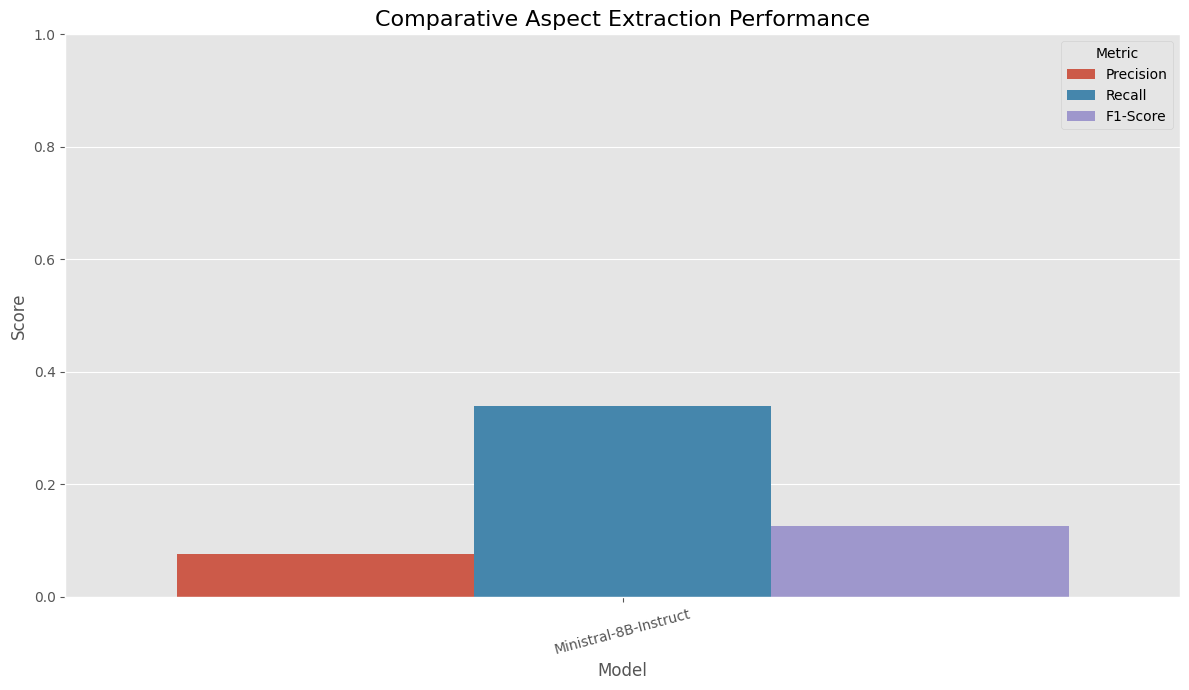

In [11]:
ae_results = {}

print("--- Starting Aspect Extraction Evaluation for all models ---")

for model_name, model_id in MODEL_CONFIG.items():
    try:
        model, tokenizer = load_model_and_tokenizer(model_id, token=HF_TOKEN)
    except Exception as e:
        print(f"Could not load {model_name}. Skipping. Error: {e}")
        continue
        
    # Prepare all AE prompts
    ae_prompts = [
        (f"Your task is to extract aspects from a given Bangla review. Aspects are the main topics or features being discussed. "
         f"List only the aspects, separated by commas. Do not add any extra explanation.\n\n"
         f"Review: \"{row['review']}\"\n\nAspects:")
        for index, row in df.iterrows()
    ]
    
    # Run batch inference
    generated_aspects_all = []
    for i in tqdm(range(0, len(ae_prompts), BATCH_SIZE), desc=f"AE Batching ({model_name})"):
        batch_prompts = ae_prompts[i:i + BATCH_SIZE]
        batch_responses = generate_response_batch(batch_prompts, model, tokenizer)
        generated_aspects_all.extend(batch_responses)

    # Evaluate results
    total_tp, total_fp, total_fn = 0, 0, 0
    for i, row in df.iterrows():
        # IMPORTANT: Make sure your column names 'review' and 'annotated_aspect' are correct.
        true_aspects_set = set([a.strip() for a in str(row['annotated_aspect']).split(',')])
        predicted_aspects_set = parse_generated_aspects(generated_aspects_all[i])
        tp, fp, fn = calculate_extraction_metrics(predicted_aspects_set, true_aspects_set)
        total_tp += tp
        total_fp += fp
        total_fn += fn

    # Store metrics for this model
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    ae_results[model_name] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1_score}

    # Clean up memory
    del model, tokenizer
    torch.cuda.empty_cache()

# --- Reporting and Visualization for Aspect Extraction ---
print("\n" + "="*80)
print("--- CONSOLIDATED ASPECT EXTRACTION RESULTS ---")
print("="*80 + "\n")

# Print a clean table
for model_name, metrics in ae_results.items():
    print(f"Model: {model_name}")
    print(f"  Precision: {metrics['Precision']:.4f}, Recall: {metrics['Recall']:.4f}, F1-Score: {metrics['F1-Score']:.4f}\n")

# Create a DataFrame for easy plotting
plot_data = []
for model_name, metrics in ae_results.items():
    for metric_name, score in metrics.items():
        plot_data.append({'Model': model_name, 'Metric': metric_name, 'Score': score})

plot_df = pd.DataFrame(plot_data)

plt.figure(figsize=(12, 7))
sns.barplot(data=plot_df, x='Model', y='Score', hue='Metric')
plt.title('Comparative Aspect Extraction Performance', fontsize=16)
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=15)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('comparative_aspect_extraction_metrics.png')
plt.show()

--- Starting Sentiment Classification Evaluation for all models ---

Loading model: mistralai/Ministral-8B-Instruct-2410


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

SC Batching (Ministral-8B-Instruct):   0%|          | 0/173 [00:00<?, ?it/s]


--- CONSOLIDATED SENTIMENT CLASSIFICATION RESULTS (ORACLE MODE) ---

--- Classification Report for Ministral-8B-Instruct ---
              precision    recall  f1-score   support

    negative       0.67      0.80      0.73       822
     neutral       0.30      0.02      0.04       572
    positive       0.70      0.89      0.78      1369

    accuracy                           0.68      2763
   macro avg       0.55      0.57      0.52      2763
weighted avg       0.61      0.68      0.61      2763



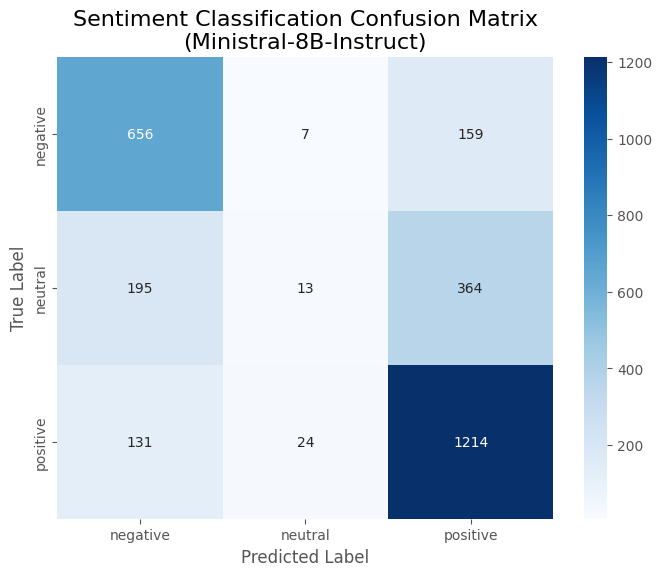

In [12]:
sc_results = {}

print("--- Starting Sentiment Classification Evaluation for all models ---")
  
for model_name, model_id in MODEL_CONFIG.items():
    try:
        model, tokenizer = load_model_and_tokenizer(model_id, token=HF_TOKEN)
    except Exception as e:
        print(f"Could not load {model_name}. Skipping. Error: {e}")  
        continue
        
    # Prepare all SC prompts
    sc_prompts_with_ground_truth = []
    # IMPORTANT: Make sure your column names 'review', 'annotated_aspect', 'annotated_sentiment' are correct.
    for index, row in df.iterrows():
        aspects = str(row['annotated_aspect']).split(',')
        sentiments = str(row['annotated_sentiment']).split(',')
        if len(aspects) != len(sentiments): continue # Skip malformed rows
        
        for aspect, sentiment in zip(aspects, sentiments):
            aspect, sentiment = aspect.strip(), sentiment.strip()
            prompt = (
                f"Given the Bangla review and a specific aspect, determine the sentiment towards that aspect. "
                f"You must answer with only one word: positive, negative, or neutral.\n\n"
                f"Review: \"{row['review']}\"\nAspect: \"{aspect}\"\n\nSentiment:")
            sc_prompts_with_ground_truth.append({'prompt': prompt, 'true_sentiment': sentiment})

    sc_prompts = [item['prompt'] for item in sc_prompts_with_ground_truth]
    true_sentiments = [item['true_sentiment'] for item in sc_prompts_with_ground_truth]
    
    # Run batch inference
    predicted_sentiments_all = []
    for i in tqdm(range(0, len(sc_prompts), BATCH_SIZE), desc=f"SC Batching ({model_name})"):
        batch_prompts = sc_prompts[i:i + BATCH_SIZE]
        batch_responses = generate_response_batch(batch_prompts, model, tokenizer)
        predicted_sentiments_all.extend(batch_responses)

    # Clean and evaluate results
    cleaned_sentiments = []
    for gen_sent in predicted_sentiments_all:
        s = gen_sent.lower()
        if "positive" in s: cleaned_sentiments.append("positive")
        elif "negative" in s: cleaned_sentiments.append("negative")
        else: cleaned_sentiments.append("neutral")

    # Store results for this model
    sc_results[model_name] = {'true': true_sentiments, 'pred': cleaned_sentiments}

    # Clean up memory
    del model, tokenizer
    torch.cuda.empty_cache()

# --- Reporting and Visualization for Sentiment Classification ---
print("\n" + "="*80)
print("--- CONSOLIDATED SENTIMENT CLASSIFICATION RESULTS (ORACLE MODE) ---")
print("="*80 + "\n")

for model_name, results in sc_results.items():
    print(f"--- Classification Report for {model_name} ---")
    true_s = results['true']
    pred_s = results['pred']
    print(classification_report(true_s, pred_s, zero_division=0))
    
    # Plotting confusion matrix
    class_names = sorted(list(set(true_s)))
    cm = confusion_matrix(true_s, pred_s, labels=class_names)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Sentiment Classification Confusion Matrix\n({model_name})', fontsize=16)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.savefig(f'comparative_sentiment_matrix_{model_name.replace("/", "_")}.png')
    plt.show()